In [19]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
import random
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical, Sequence

In [20]:
data_path = "data_horse"
labels_file = "data_horse_human/bboxes.json"


In [21]:
with open(labels_file) as f:
    dict_data = json.load(f)

In [32]:
colors = [(255, 0, 0),
           (0, 0, 255),
           (0, 255, 0),
           (0, 255, 255),
           (0, 102, 0),
           (255, 0, 255),
           (255, 255, 0),
           (255, 102, 255),
           (0, 51, 102),
           (51, 153, 255)]

labels_ref = [
    "0",
    "1",
]

In [33]:
img_size = (256, 256, 3)
class_nb = 2 + 1
nb_boxes = 5
grid_w = 7
grid_h = 7
cell_w = img_size[0] // grid_w
cell_h = img_size[1] // grid_h
img_w = grid_w * cell_w
img_h = grid_h * cell_h

batch_size = 8

In [34]:
rotations = [0, 90, 180, 270]
class DataGenerator(Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, shuffle=False, preprocess=False):
        super().__init__()
        self.data = data
        self.file_names = np.array(list(self.data.keys()))
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_size[1], img_size[0], img_size[2]), dtype=np.float32)
        y = np.empty((self.batch_size, grid_w * grid_h, nb_boxes, (class_nb + 5)), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, f in enumerate([self.file_names[idx] for idx in indexes]):
            if self.preprocess:
                rot_idx = np.random.randint(4)
            else:
                rot_idx = 0
            im = Image.open(os.path.join(self.data_path, f)).resize((img_size[0], img_size[1]))
            im = im.rotate(rotations[rot_idx])
            X[i,] = np.array(im) / 255.0
            data = self.data[f]
            if rot_idx == 0:
                pass
            elif rot_idx == 1:
                data = {c: [[r[1], 1-r[0], r[3], r[2]] for r in rcts] for c, rcts in data.items()}
            elif rot_idx == 2:
                data = {c: [[1-r[0], 1-r[1], r[2], r[3]] for r in rcts] for c, rcts in data.items()}
            else:
                data = {c: [[1-r[1], r[0], r[3], r[2]] for r in rcts] for c, rcts in data.items()}
            yolo_out = build_yolo_out(data, rot_idx)
            y[i,] = yolo_out
        return X, y

In [40]:
def rect_is_in_cell(rect, row, col):
    if rect[0] * img_w > col * cell_w and rect[0] * img_w <= col * cell_w + cell_w and \
        rect[1] * img_h > row * cell_h and rect[1] * img_h <= row * cell_h + cell_h:
            return True
    return False

def build_yolo_out(data, rot_idx):
    y_t = []
    for row in range(grid_h):
        for col in range(grid_w):
            found = False
            rects = []
            for class_name in data:
                class_id = labels_ref.index(class_name) + 1
                for rect in data[class_name]:
                    if rect_is_in_cell(rect, row, col):
                        rects.append(rect + [class_id])
            if len(rects):
                
                #confidence
                conf_t = [1]
                elt = []

                for j, rect in enumerate(rects):
                    #class
                    c_t = list(to_categorical(int(rect[4]), num_classes=class_nb))
                    #define center position and w h
                    cx = rect[0] if rect[0] >= 0 else 0
                    cy = rect[1] if rect[1] >= 0 else 0
                    cw = rect[2] if rect[2] >= 0 else 0
                    ch = rect[3] if rect[3] >= 0 else 0
                    cx = cx if cx <= 1 else 1
                    cy = cy if cy <= 1 else 1
                    cw = cw if cw <= 1 else 1
                    ch = ch if ch <= 1 else 1
                    x = cx * img_w
                    y = cy * img_h
                    rel_x = (x - (col * cell_w)) / cell_w
                    rel_y = (y - (row * cell_h)) / cell_h
                    [x, y, w, h] = [rel_x, rel_y, cw, ch]
                    if len(rects) > 1:
                        if j < len(rects)-1:
                            for b in range(nb_boxes // len(rects)):
                                elt.append(c_t + [x, y, w, h] + conf_t)
                        else:
                            for b in range((nb_boxes // len(rects)) + (nb_boxes % len(rects))):
                                elt.append(c_t + [x, y, w, h] + conf_t)
                    else:
                        for b in range(nb_boxes):
                            #print(w, h)
                            elt.append(c_t + [x, y, w, h] + conf_t)
                y_t.append(elt)
                found = True

            if found == False:
                elt = []
                #class
                c_t = list(to_categorical(0, num_classes=class_nb))
                #define center position and w h
                rel_x = (cell_w / 2) / cell_w
                rel_y = (cell_h / 2) / cell_h
                [x, y, w, h] = [rel_x, rel_y, cell_w / img_w, cell_h / img_h]
                #confidence
                conf_t = [0]
                
                for b in range(nb_boxes):
                    elt.append(c_t + [x, y, w, h] + conf_t)
                y_t.append(elt)
            
    return y_t

In [54]:
shuffled_dict_keys = list(dict_data.keys())
random.shuffle(shuffled_dict_keys)
shuffled_dict_data = dict()
for key in shuffled_dict_keys:
    shuffled_dict_data.update({key:dict_data[key]})
                
batch_size = 8
train_batches = DataGenerator(shuffled_dict_data, data_path, class_nb, batch_size=batch_size, preprocess=True)

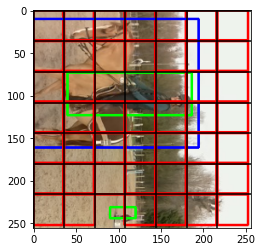

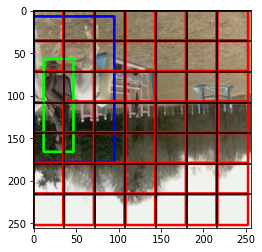

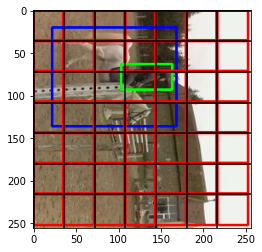

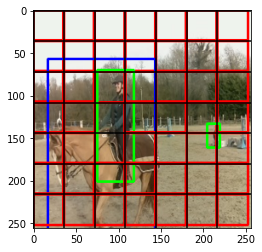

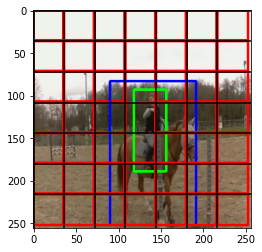

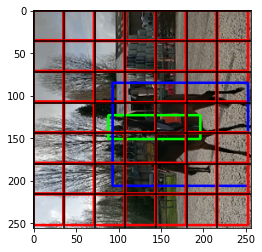

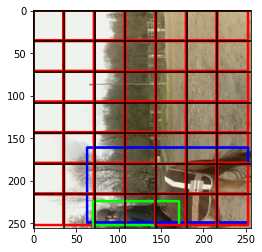

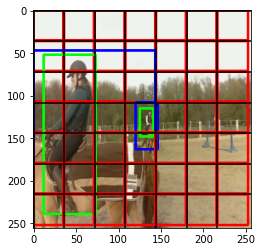

In [55]:
for batch in train_batches:
    for i in range(batch_size):
        img = (batch[0][i,] * 255).astype('uint8')
        for n, rects in enumerate(batch[1][i,]):
            for r, label in enumerate(rects):
                row = int(n / grid_h)
                col = n - (row * grid_w)
                x = (label[class_nb + 0] * cell_w) + (col * cell_w)
                y = (label[class_nb + 1] * cell_h) + (row * cell_h) 
                w = label[class_nb + 2] * img_w
                h = label[class_nb + 3] * img_h
                pt1 = (int(x - (w / 2)), int(y - (h / 2)))
                pt2 = (int(x + (w / 2)), int(y + (h / 2)))
                cv2.rectangle(img, pt1, pt2, colors[np.argmax(label[:class_nb])], thickness=2)
        plt.figure()
        plt.imshow(img)
        for row in range(grid_w):
            plt.axvline(x=row*cell_w,color='black')
        for col in range(grid_h):
            plt.axhline(y=col*cell_h,color='black')
    break

In [56]:
l_coords = 3
def custom_loss(y_true, y_pred):

    y_true_class = y_true[...,:class_nb]
    y_pred_class = y_pred[...,:class_nb]

    pred_boxes = tf.reshape(y_pred[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    true_boxes = tf.reshape(y_true[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    
    y_pred_xy   = pred_boxes[...,0:2]
    y_pred_wh   = pred_boxes[...,2:4]
    y_pred_conf = pred_boxes[...,4]

    y_true_xy   = true_boxes[...,0:2]
    y_true_wh   = true_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    clss_loss  = tf.math.reduce_sum(tf.math.square(y_true_class - y_pred_class)) #* y_true_conf
    xy_loss    = tf.math.reduce_sum(tf.math.square(y_true_xy - y_pred_xy)) * y_true_conf
    # sqrt on wh to penalize bigger boxes
    wh_loss    = tf.math.reduce_sum(tf.math.square(tf.math.sqrt(y_true_wh) - tf.math.sqrt(y_pred_wh))) * y_true_conf
    #wh_loss    = tf.math.reduce_sum(tf.math.square(y_true_wh - y_pred_wh)) * y_true_conf
    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # minimum distance between boxes distance between the two center
    intersect_wh = tf.maximum(tf.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - tf.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    
    true_area  = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area  = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    
    iou = intersect_area / union_area

    conf_loss = tf.math.square(y_true_conf * iou - y_pred_conf) * y_true_conf

    return clss_loss + l_coords * xy_loss + l_coords * wh_loss + conf_loss

In [88]:
K.clear_session()

leaky_alpha = 0.1

img_in = Input(shape=(img_size[1], img_size[0], img_size[2]), name='img_in')

x = Conv2D(16, 1, padding='same')(img_in)
x = Conv2D(32, 3, strides=2,padding='same')(x)
x = LeakyReLU(alpha=leaky_alpha)(x)
x = BatchNormalization()(x)

x = Conv2D(16, 1, padding='same')(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = LeakyReLU(alpha=leaky_alpha)(x)
x = BatchNormalization()(x)

x = Conv2D(32, 1, padding='same')(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = LeakyReLU(alpha=leaky_alpha)(x)
x = BatchNormalization()(x)

x = Conv2D(64, 1, padding='same')(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = LeakyReLU(alpha=leaky_alpha)(x)
x = BatchNormalization()(x)

x = Conv2D(128, 1, padding='same')(x)
x = Conv2D(256, 3, strides=2, padding='same')(x)
x = LeakyReLU(alpha=leaky_alpha)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w * grid_h * (class_nb + 5) * nb_boxes, activation='sigmoid')(x)
out = Reshape((grid_w * grid_h, nb_boxes, (class_nb + 5)))(x)

model = Model(inputs=img_in, outputs=out)

model.compile(optimizer=Optimizers.Adam(learning_rate=1e-3), loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      528       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640  

In [89]:
model_name = "model_horse_128.h5"
#save best model if model improved
best_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [90]:
idx = int(0.9*len(shuffled_dict_data))
train_data = {k: shuffled_dict_data[k] for k in list(shuffled_dict_data)[:idx]}
val_data = {k: shuffled_dict_data[k] for k in list(shuffled_dict_data)[idx:]}

train_batches = DataGenerator(train_data, data_path, class_nb, batch_size=batch_size, preprocess=True, shuffle=True)
val_batches = DataGenerator(val_data, data_path, class_nb, batch_size=batch_size)

history = model.fit(train_batches, validation_data=val_batches, epochs=400, verbose=1, callbacks=[best_checkpoint])

Epoch 1/400
21/21 [==============================] - 3s 68ms/step - loss: 466.4539 - val_loss: 222.7853

Epoch 00001: val_loss improved from inf to 222.78529, saving model to model_horse_128.h5
Epoch 2/400
21/21 [==============================] - 1s 52ms/step - loss: 170.8916 - val_loss: 152.2609

Epoch 00002: val_loss improved from 222.78529 to 152.26093, saving model to model_horse_128.h5
Epoch 3/400
21/21 [==============================] - 1s 60ms/step - loss: 169.0524 - val_loss: 144.5533

Epoch 00003: val_loss improved from 152.26093 to 144.55327, saving model to model_horse_128.h5
Epoch 4/400
21/21 [==============================] - 1s 55ms/step - loss: 168.0039 - val_loss: 138.2253

Epoch 00004: val_loss improved from 144.55327 to 138.22528, saving model to model_horse_128.h5
Epoch 5/400
21/21 [==============================] - 1s 52ms/step - loss: 168.1786 - val_loss: 140.0898

Epoch 00005: val_loss did not improve from 138.22528
Epoch 6/400
21/21 [=============================

Epoch 49/400
21/21 [==============================] - 1s 53ms/step - loss: 113.5281 - val_loss: 109.3899

Epoch 00049: val_loss improved from 112.62157 to 109.38986, saving model to model_horse_128.h5
Epoch 50/400
21/21 [==============================] - 1s 52ms/step - loss: 111.9274 - val_loss: 118.4079

Epoch 00050: val_loss did not improve from 109.38986
Epoch 51/400
21/21 [==============================] - 1s 51ms/step - loss: 109.8249 - val_loss: 111.1282

Epoch 00051: val_loss did not improve from 109.38986
Epoch 52/400
21/21 [==============================] - 1s 52ms/step - loss: 108.5668 - val_loss: 112.7848

Epoch 00052: val_loss did not improve from 109.38986
Epoch 53/400
21/21 [==============================] - 1s 51ms/step - loss: 106.0827 - val_loss: 113.1850

Epoch 00053: val_loss did not improve from 109.38986
Epoch 54/400
21/21 [==============================] - 1s 52ms/step - loss: 103.5271 - val_loss: 112.3310

Epoch 00054: val_loss did not improve from 109.38986
Epoc

21/21 [==============================] - 1s 51ms/step - loss: 61.2114 - val_loss: 89.2362

Epoch 00098: val_loss did not improve from 83.63183
Epoch 99/400
21/21 [==============================] - 1s 53ms/step - loss: 60.6894 - val_loss: 91.1099

Epoch 00099: val_loss did not improve from 83.63183
Epoch 100/400
21/21 [==============================] - 1s 51ms/step - loss: 59.8149 - val_loss: 84.9380

Epoch 00100: val_loss did not improve from 83.63183
Epoch 101/400
21/21 [==============================] - 1s 51ms/step - loss: 60.6973 - val_loss: 79.4328

Epoch 00101: val_loss improved from 83.63183 to 79.43283, saving model to model_horse_128.h5
Epoch 102/400
21/21 [==============================] - 1s 53ms/step - loss: 57.6926 - val_loss: 89.2031

Epoch 00102: val_loss did not improve from 79.43283
Epoch 103/400
21/21 [==============================] - 1s 52ms/step - loss: 56.0759 - val_loss: 85.4983

Epoch 00103: val_loss did not improve from 79.43283
Epoch 104/400
21/21 [===========

21/21 [==============================] - 1s 52ms/step - loss: 30.3020 - val_loss: 78.3120

Epoch 00149: val_loss did not improve from 73.71232
Epoch 150/400
21/21 [==============================] - 1s 53ms/step - loss: 28.4433 - val_loss: 75.0321

Epoch 00150: val_loss did not improve from 73.71232
Epoch 151/400
21/21 [==============================] - 1s 52ms/step - loss: 29.2952 - val_loss: 75.7114

Epoch 00151: val_loss did not improve from 73.71232
Epoch 152/400
21/21 [==============================] - 1s 52ms/step - loss: 28.7004 - val_loss: 76.3473

Epoch 00152: val_loss did not improve from 73.71232
Epoch 153/400
21/21 [==============================] - 1s 51ms/step - loss: 28.0442 - val_loss: 76.5754

Epoch 00153: val_loss did not improve from 73.71232
Epoch 154/400
21/21 [==============================] - 1s 52ms/step - loss: 29.3068 - val_loss: 77.5709

Epoch 00154: val_loss did not improve from 73.71232
Epoch 155/400
21/21 [==============================] - 1s 54ms/step - lo

21/21 [==============================] - 1s 52ms/step - loss: 15.1592 - val_loss: 74.3630

Epoch 00200: val_loss did not improve from 66.92073
Epoch 201/400
21/21 [==============================] - 1s 52ms/step - loss: 15.5340 - val_loss: 73.6444

Epoch 00201: val_loss did not improve from 66.92073
Epoch 202/400
21/21 [==============================] - 1s 52ms/step - loss: 14.3092 - val_loss: 67.4564

Epoch 00202: val_loss did not improve from 66.92073
Epoch 203/400
21/21 [==============================] - 1s 52ms/step - loss: 14.4447 - val_loss: 69.6169

Epoch 00203: val_loss did not improve from 66.92073
Epoch 204/400
21/21 [==============================] - 1s 52ms/step - loss: 14.8165 - val_loss: 73.1750

Epoch 00204: val_loss did not improve from 66.92073
Epoch 205/400
21/21 [==============================] - 1s 52ms/step - loss: 13.2358 - val_loss: 71.9912

Epoch 00205: val_loss did not improve from 66.92073
Epoch 206/400
21/21 [==============================] - 1s 52ms/step - lo

21/21 [==============================] - 1s 54ms/step - loss: 8.4220 - val_loss: 72.2357

Epoch 00252: val_loss did not improve from 65.87406
Epoch 253/400
21/21 [==============================] - 1s 52ms/step - loss: 7.7286 - val_loss: 70.6255

Epoch 00253: val_loss did not improve from 65.87406
Epoch 254/400
21/21 [==============================] - 1s 53ms/step - loss: 6.9194 - val_loss: 69.2011

Epoch 00254: val_loss did not improve from 65.87406
Epoch 255/400
21/21 [==============================] - 1s 55ms/step - loss: 8.2288 - val_loss: 73.0215

Epoch 00255: val_loss did not improve from 65.87406
Epoch 256/400
21/21 [==============================] - 1s 56ms/step - loss: 8.2443 - val_loss: 71.7448

Epoch 00256: val_loss did not improve from 65.87406
Epoch 257/400
21/21 [==============================] - 1s 52ms/step - loss: 8.2634 - val_loss: 69.2393

Epoch 00257: val_loss did not improve from 65.87406
Epoch 258/400
21/21 [==============================] - 1s 54ms/step - loss: 8.


Epoch 00304: val_loss did not improve from 65.87406
Epoch 305/400
21/21 [==============================] - 1s 51ms/step - loss: 5.6996 - val_loss: 70.9288

Epoch 00305: val_loss did not improve from 65.87406
Epoch 306/400
21/21 [==============================] - 1s 50ms/step - loss: 5.8942 - val_loss: 71.0702

Epoch 00306: val_loss did not improve from 65.87406
Epoch 307/400
21/21 [==============================] - 1s 51ms/step - loss: 5.7530 - val_loss: 74.7106

Epoch 00307: val_loss did not improve from 65.87406
Epoch 308/400
21/21 [==============================] - 1s 50ms/step - loss: 5.9603 - val_loss: 72.1995

Epoch 00308: val_loss did not improve from 65.87406
Epoch 309/400
21/21 [==============================] - 1s 50ms/step - loss: 5.0397 - val_loss: 71.1612

Epoch 00309: val_loss did not improve from 65.87406
Epoch 310/400
21/21 [==============================] - 1s 49ms/step - loss: 6.4868 - val_loss: 72.0942

Epoch 00310: val_loss did not improve from 65.87406
Epoch 311/4

21/21 [==============================] - 1s 50ms/step - loss: 4.6436 - val_loss: 74.7542

Epoch 00357: val_loss did not improve from 65.87406
Epoch 358/400
21/21 [==============================] - 1s 50ms/step - loss: 4.0607 - val_loss: 74.8759

Epoch 00358: val_loss did not improve from 65.87406
Epoch 359/400
21/21 [==============================] - 1s 50ms/step - loss: 4.2862 - val_loss: 74.3281

Epoch 00359: val_loss did not improve from 65.87406
Epoch 360/400
21/21 [==============================] - 1s 50ms/step - loss: 3.8430 - val_loss: 73.3737

Epoch 00360: val_loss did not improve from 65.87406
Epoch 361/400
21/21 [==============================] - 1s 50ms/step - loss: 3.9162 - val_loss: 73.1105

Epoch 00361: val_loss did not improve from 65.87406
Epoch 362/400
21/21 [==============================] - 1s 50ms/step - loss: 4.3030 - val_loss: 74.6606

Epoch 00362: val_loss did not improve from 65.87406
Epoch 363/400
21/21 [==============================] - 1s 51ms/step - loss: 4.

<AxesSubplot:>

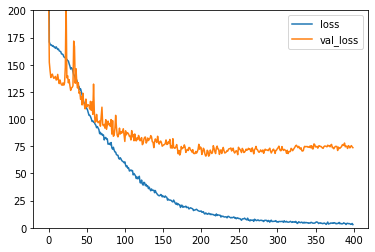

In [91]:
#print History graph
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,200))

In [92]:
# LOAD MODEL
from tensorflow.keras.models import load_model
from deepctr.layers import custom_objects

custom_objects["custom_loss"] = custom_loss
model = load_model(model_name, custom_objects=custom_objects)

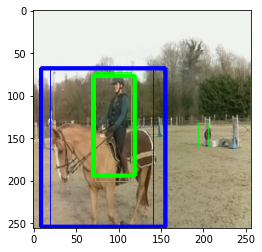

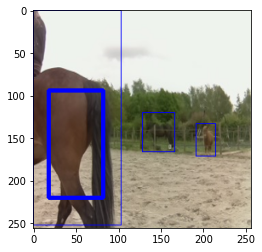

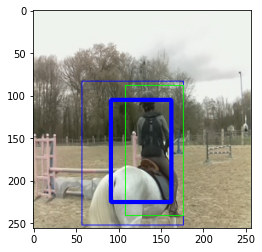

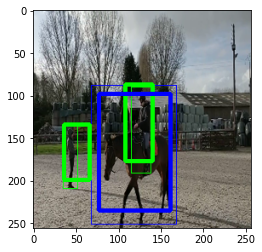

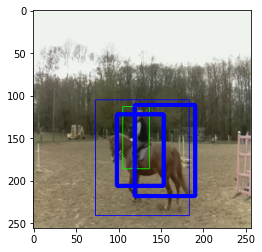

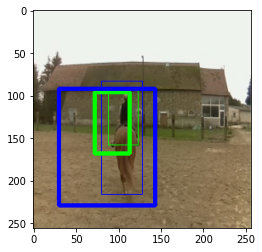

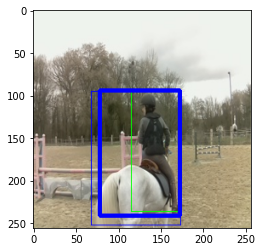

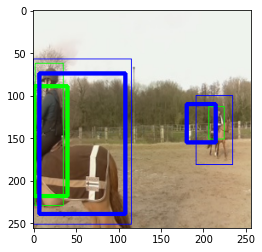

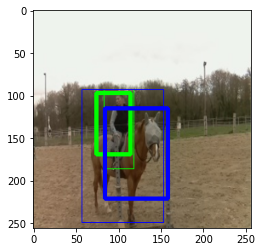

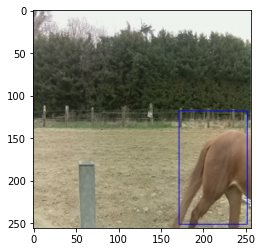

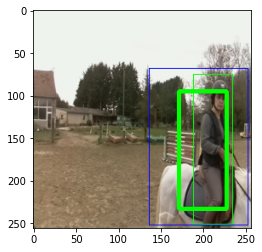

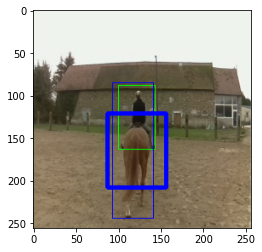

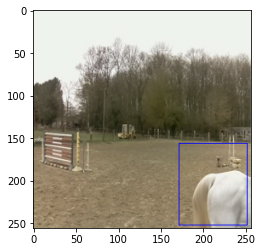

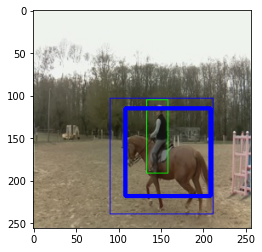

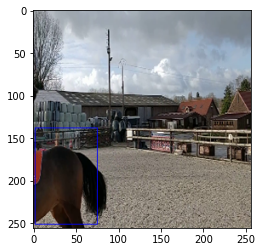

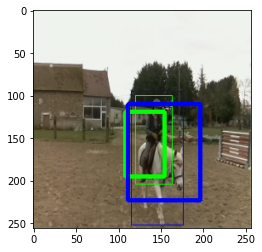

In [93]:
nb = 0
for batch in val_batches:
    nb += 1
    for i in range(batch_size):
        img = batch[0][i,]
        pred = model.predict(img.reshape((1, img_size[1], img_size[0], img_size[2])))
        img = (img * 255).astype('uint8')
        for n, rects in enumerate(batch[1][i,]):
            for r, label in enumerate(rects):
                row = int(n / grid_h)
                col = n - (row * grid_w)
                x = (label[class_nb + 0] * cell_w) + (col * cell_w)
                y = (label[class_nb + 1] * cell_h) + (row * cell_h) 
                w = label[class_nb + 2] * img_w
                h = label[class_nb + 3] * img_h
                pt1 = (int(x - (w / 2)), int(y - (h / 2)))
                pt2 = (int(x + (w / 2)), int(y + (h / 2)))
                cls = np.argmax(label[:class_nb])
                if cls > 0:
                    cv2.rectangle(img, pt1, pt2, colors[cls], 1, cv2.LINE_8)
        for n, rects in enumerate(pred[0]):
            #for b, label in enumerate(rects):
            #print(rects[...,4])
            b = np.argmax(rects[...,4])
            label = rects[b]
            row = int(n / grid_h)
            col = n - (row * grid_w)
            x = label[class_nb + 0] * cell_w + col * cell_w
            y = label[class_nb + 1] * cell_h + row * cell_h
            w = label[class_nb + 2] * img_w
            h = label[class_nb + 3] * img_h
            pt1 = (int(x - (w / 2)), int(y - (h / 2)))
            pt2 = (int(x + (w / 2)), int(y + (h / 2)))
            cls = np.argmax(label[:class_nb])
            if cls > 0:
                cv2.rectangle(img, pt1, pt2, colors[cls], 3)
        plt.figure()
        plt.imshow(img)
    if nb > 4:
        break